In [5]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import time as time
import datetime as datetime
import sklearn.metrics
if __name__ == "__main__":
    hours = 8
    time_secs = hours * 3600
    target_feature = "eventRateOut"
    filename = "mininet_accident_5s_combined_samples.csv"

    # keep target metrics
    selected_features_throughput = ["Relaxation", "Rizou", "ProducerConsumer", "Random", "GlobalOptimalBDP", "MDCEP",
                                    "operatorSelectivity", "eventRateIn", "processingLatencyMean", "processingLatencyStdDev",
                                    "networkParentLatencyMean", "brokerCPULoad", "eventRateOut"]
    selected_features_processing_latency = ["Relaxation", "Rizou", "ProducerConsumer", "Random", "GlobalOptimalBDP", "MDCEP",
                                            "eventSizeInKB", "operatorSelectivity", "interArrivalMean", "interArrivalStdDev",
                                            "brokerCPULoad", "eventRateOut", "processingLatencyMean"]

    selected_dict = { "eventRateOut" : selected_features_throughput, "processingLatencyMean" : selected_features_processing_latency}

    # requires JRE 8 at least
    h2o.init(max_mem_size_GB=16)
    df = h2o.import_file(filename, header=1)

    start_time = time.time()
    print("starting training at ", datetime.datetime.now().strftime('%H:%M:%S'))
    df = df[selected_dict[target_feature]]
    print(df)

    d = df.split_frame(ratios = [0.66])
    df_train = d[0] # using 66% for training
    df_test = d[1] #rest 34% for testing
    y_test = df_test[target_feature]
    features = list(df.columns)
    features.remove(target_feature)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxj854he4
  JVM stdout: /tmp/tmpxj854he4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxj854he4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_m9it3i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.67 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
starting training at  03:26:37
AutoML progress: |
03:26:38.84: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210604_032638,122.549,11.0702,122.549,3.79995,nan
StackedEnsemble_BestOfFamily_AutoML_20210604_032638,147.697,12.1531,147.697,4.17493,nan
GBM_grid__1_AutoML_20210604_032638_model_14,167.533,12.9435,167.533,4.07907,nan
GBM_3_AutoML_20210604_032638,168.977,12.9991,168.977,4.71133,nan
GBM_1_AutoML_20210604_032638,171.856,13.1094,171.856,4.226,0.128585
GBM_grid__1_AutoML_20210604_032638_model_17,176.078,13.2694,176.078,4.50567,nan
GBM_4_AutoML_20210604_032638,179.214,13.3871,179.214,4.69448,nan
GBM_grid__1_AutoML_20210604_032638_model_3,182.11,13.4948,182.11,3.9708,nan
GBM_2_AutoML_20210604_032638,184.058,13.5668,184.058,4.87755,nan
XGBoost_2_AutoML_20210604_032638,189.567,13.7683,189.567,5.26526,nan



stackedensemble prediction progress: |████████████████████████████████████| 100%
finished after  34.915311439999996


In [ ]:
    automl = H2OAutoML(max_runtime_secs=time_secs,
                       #export_checkpoints_dir='model_checkpoints',
                       sort_metric='rmse')
    automl.train(x = features, y = target_feature, training_frame = df_train, validation_frame = df_test)
    end_time = time.time()
    print(automl.leaderboard)

In [ ]:
    predictions = automl.leader.predict(df_test)
    predictions = h2o.as_list(predictions)
    print("finished after ", end_time - start_time)

    model_filename = 'output/h2o_trained_pipeline_' + str(hours) + '_' + filename + '_' + target_feature
    # Get model ids for all models in the AutoML Leaderboard
    model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
    #print(model_ids)
    print(model_ids[0])
    target_idx = 0
    if "StackedEnsemble_AllModels" in str(model_ids[0]):
        target_idx = 1
        target_id = model_ids[1]
        print("saving the second best model if the stacked model with all models is best; too slow for production predictions, instead: ", target_id)
    else:
        target_id = model_ids[0]
    h2o.save_model(h2o.get_model(target_id), path = model_filename)

In [ ]:
    #lb = h2o.automl.get_leaderboard(automl, extra_columns = 'ALL')
    #print(lb)

    # Get the "All Models" Stacked Ensemble model
    #se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
    #print(se)
    # Get the Stacked Ensemble metalearner model
    #metalearner = h2o.get_model(se.metalearner()['name'])
    #print(metalearner)
    leaderboard_data = automl.leaderboard.as_data_frame()
    #print(leaderboard_data)

    mse = leaderboard_data["mse"][target_idx]
    rmse = leaderboard_data["rmse"][target_idx]
    mae = leaderboard_data["mae"][target_idx]

    print("mean squared error: ", mse)
    print("root mean squared error: ", rmse)
    print("mean absolute error: ", mae)

    with open('h2o' + str(hours) + 'h_' + filename + '_' + target_feature + '_scores.csv', 'w') as sc:
        sc.write('framework,training_time,target_metric,RMSE,MSE,MAE,mean_abs_percentage_error,median_abs_error,r2,pipeline\n')
        sc.write('h2o,' + str(hours) + ',' + target_feature + ',' + str(rmse) + ',' + str(mse) + ',' + str(mae) + ','
                 + "NaN" + ',' + "NaN" + ',' + "NaN" + ',' + str(target_id))

In [ ]:
    automl.explain(automl.leader)

2329 2329


ValueError: Input could not be cast to an at-least-1D NumPy array

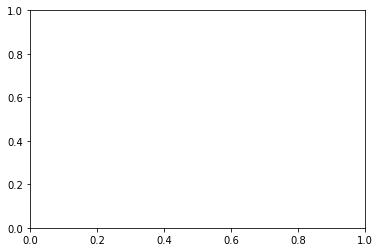

In [9]:
    print(len(y_test), len(predictions))
    #plt.plot(y_test.to_numpy()[:50], alpha=0.3, label="truth", color="limegreen")
    plt.plot(predictions[:50], alpha=0.3, label="predicted", color="red")
    #plt.semilogy()
    plt.grid()
    plt.legend()
    plt.ylabel("e2eLatency")
    plt.xlabel("Time")

TypeError: 'H2OStackedEnsembleEstimator' object is not subscriptable